# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [3]:
df_offers = pd.read_excel("WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [8]:
#your turn
df = df_offers.merge(df_transactions, on='offer_id', how='outer')
df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [22]:
#pivot the table, so that
#each row is a customer_name
#each column is an offer
#each cell is a 0/1 for a response

matrix = pd.pivot_table(df, 
                        values='n',
                        index='customer_name',
                        columns=['offer_id'], 
                        aggfunc='count')

matrix = matrix.fillna(0)

matrix = matrix.astype(int)

matrix.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

#### 1. What values of  𝑆𝑆  do you believe represent better clusterings? Why?

There is balance between SS and k. The goal is to decrease SS as much as possible, but along SS decreasing, k increases resulting in overfitting. That's why 'elbow method' is used. The SS is reduced dramatically from 1 to 2 to 3, however, the overfitting has not come into play.

#### 2. Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums)

In [23]:
x_cols = matrix.as_matrix()
x_cols

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]])

#### 3. Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix.

In [25]:
from sklearn.cluster import KMeans

k=3 #number of clusters

model = KMeans(n_clusters=k, random_state=1) #initial the model

labels = model.fit_predict(x_cols) #fit and predict the labels for each consumer

print(labels)

[1 2 0 1 2 2 0 1 2 1 2 0 1 2 1 0 2 0 1 2 1 1 2 2 0 2 2 2 2 0 2 1 2 2 1 1 2
 1 2 1 0 0 1 2 1 2 1 2 2 2 2 2 2 0 2 1 0 2 1 2 2 1 2 1 1 0 0 2 2 2 2 2 2 1
 2 1 0 2 2 0 0 0 2 0 1 1 1 0 1 1 2 1 2 1 2 2 1 2 2 2]


#### 4. Construct a plot showing  𝑆𝑆  for each  𝐾  and pick  𝐾  using this plot. For simplicity, test  2≤𝐾≤10 .

    k          ss
0   1  281.900000
1   2  251.460317
2   3  230.254028
3   4  214.654845
4   5  205.579814
5   6  198.076190
6   7  188.437302
7   8  180.903413
8   9  171.222727
9  10  164.762493


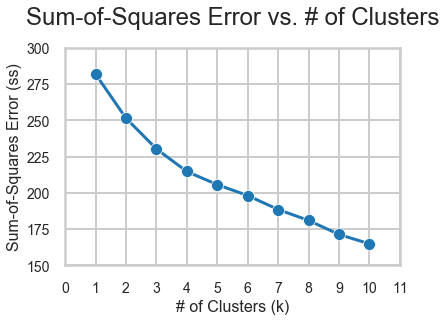

In [26]:
# list used to collect the different k values and their respective errors
k_ss = []

# range of possible number of clusters or k values
k_pos = range(1,11)

for k in k_pos:

    # initialize the model
    model = KMeans(n_clusters=k, random_state=1)

    # fit and predict the labels for each customer
    labels = model.fit_predict(x_cols)
    
    # calculate ss
    k_ss.append([k, model.inertia_])

# convert the list into a df
df_k_ss = pd.DataFrame(k_ss, columns = ['k', 'ss'])
print(df_k_ss)

# plot ss vs k
_ = sns.lineplot(x='k', 
                 y='ss', 
                 data=df_k_ss, 
                 marker='o')
_ = plt.title('Sum-of-Squares Error vs. # of Clusters', y=1.08)
_ = plt.xlabel('# of Clusters (k)', fontsize=16)
_ = plt.ylabel('Sum-of-Squares Error (ss)', fontsize=16)
_ = plt.xticks(range(12), fontsize = 14)
_ = plt.yticks(range(150, 301, 25), fontsize = 14)

According to the Elbow method, a k value is selected by choosing the k where the slope changes the most from steep to shallow. The slope from k=0 to k=3 is fairly different than from k=3 to k=10. So using the Elbow method, the k should be 3.

#### 5. Make a bar chart showing the number of points in each cluster for k-means under the best  𝐾 

   Labels  Count
0       0     19
1       1     32
2       2     49


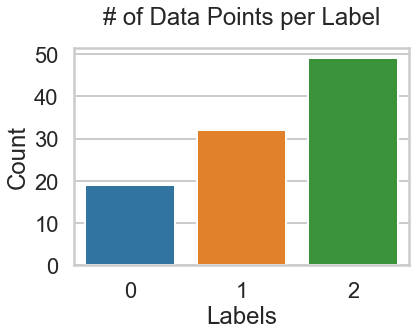

In [28]:
k_best = 3

model = KMeans(n_clusters=k_best, random_state=1)

# fit and predict the labels for each customer
labels = model.fit_predict(x_cols)

# collects the label and how many times it's in the list
clust_count = []

# count the number of times a label appears in the list
for i in range(len(set(labels))):
    clust_count.append([i, list(labels).count(i)])

# convert the list into a df
df_clust_count = pd.DataFrame(clust_count, columns = ['Labels', 'Count'])
print(df_clust_count)

# plot counts vs labels
_ = sns.barplot(x='Labels', 
                y='Count', 
                data=df_clust_count)
_ = plt.title('# of Data Points per Label', y=1.08)
_ = plt.yticks(range(0, 51, 10))

#### 6. What challenges did you experience using the Elbow method to pick  𝐾 ?

In this particular example, the 'elbow' is not that clearly defined in the plot. By eye, k=3 seems reasonable, but it is not conclusive and different people may select different k values which will dramatically change the output.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
For n_clusters = 3 The average silhouette_score is : 0.1107183912025193
For n_clusters = 4 The average silhouette_score is : 0.12349204708263416
For n_clusters = 5 The average silhouette_score is : 0.11482891379977885
For n_clusters = 6 The average silhouette_score is : 0.11879508142787866
For n_clusters = 7 The average silhouette_score is : 0.10874624428071616
For n_clusters = 8 The average silhouette_score is : 0.14097216560635834
For n_clusters = 9 The average silhouette_score is : 0.14178613108021745
For n_clusters = 10 The average silhouette_score is : 0.12819851045484193
For n_clusters = 11 The average silhouette_score is : 0.14290508438443225
For n_clusters = 12 The average silhouette_score is : 0.12148475710915038
For n_clusters = 13 The average silhouette_score is : 0.12333906886977053
For n_clusters = 14 The average silhouette_score is : 0.1320262787650173


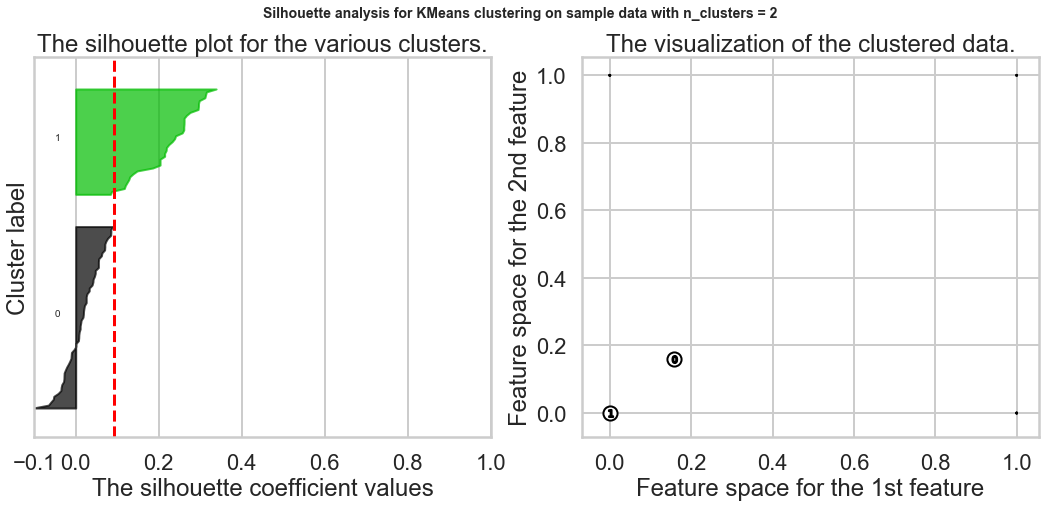

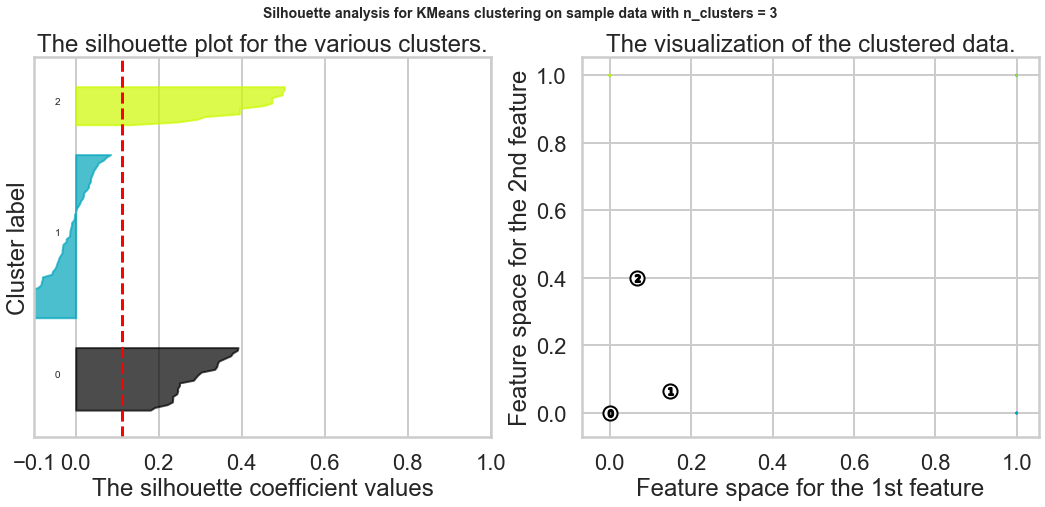

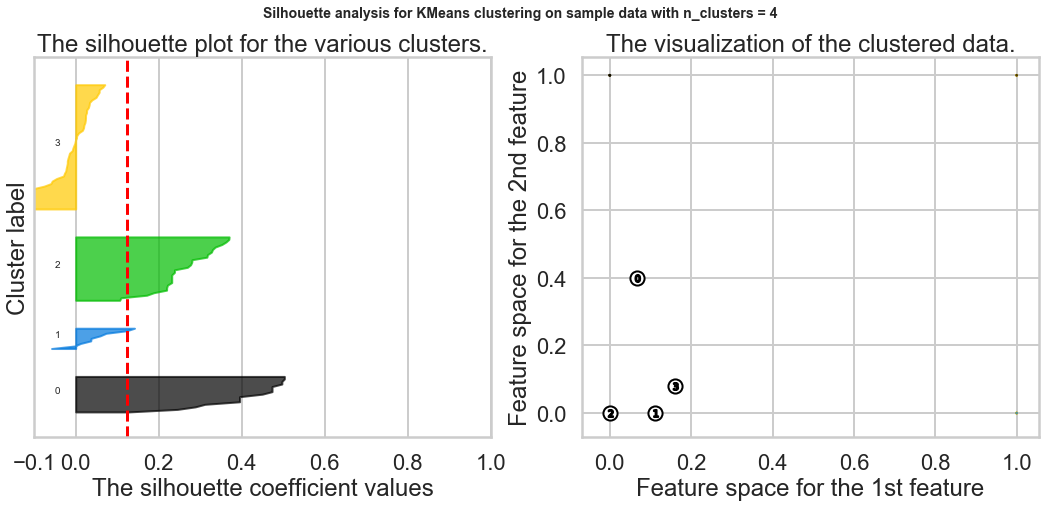

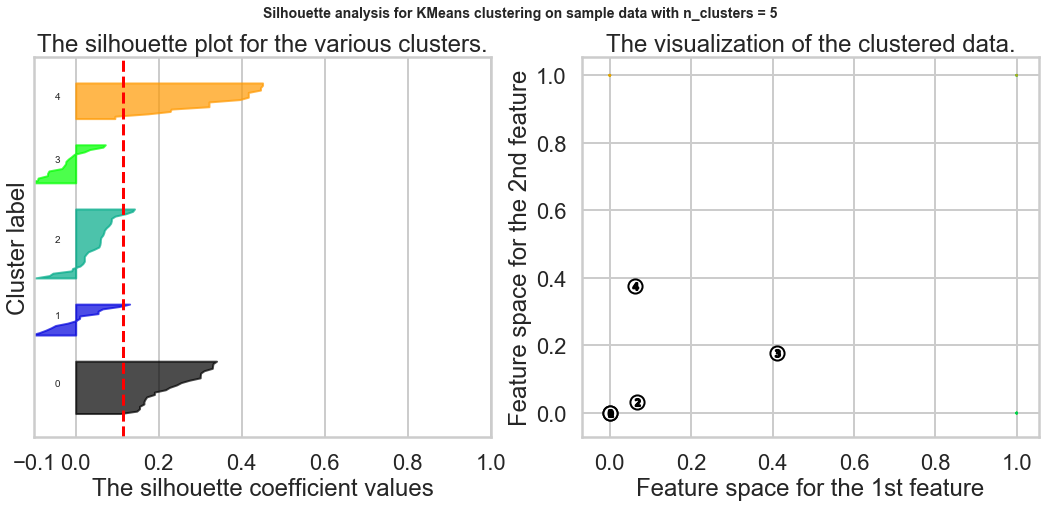

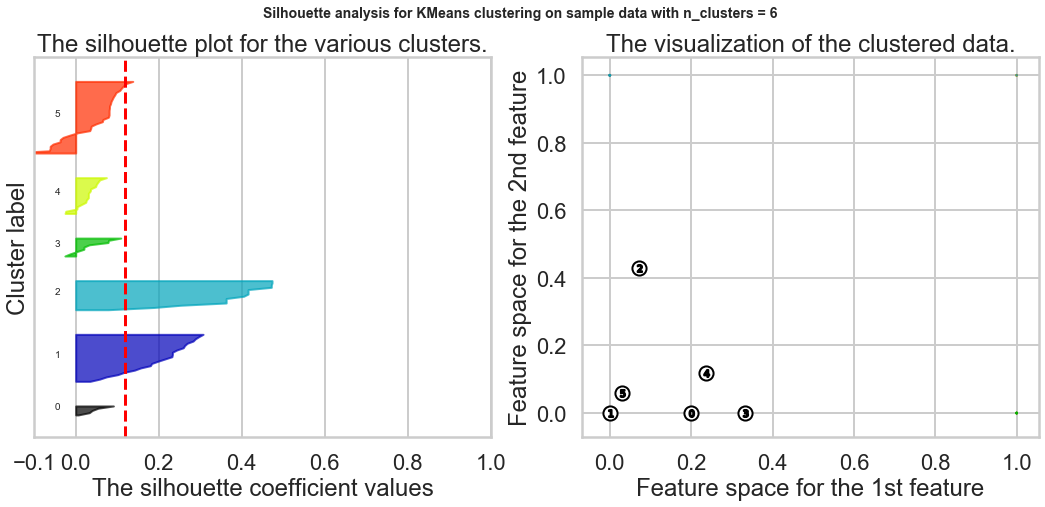

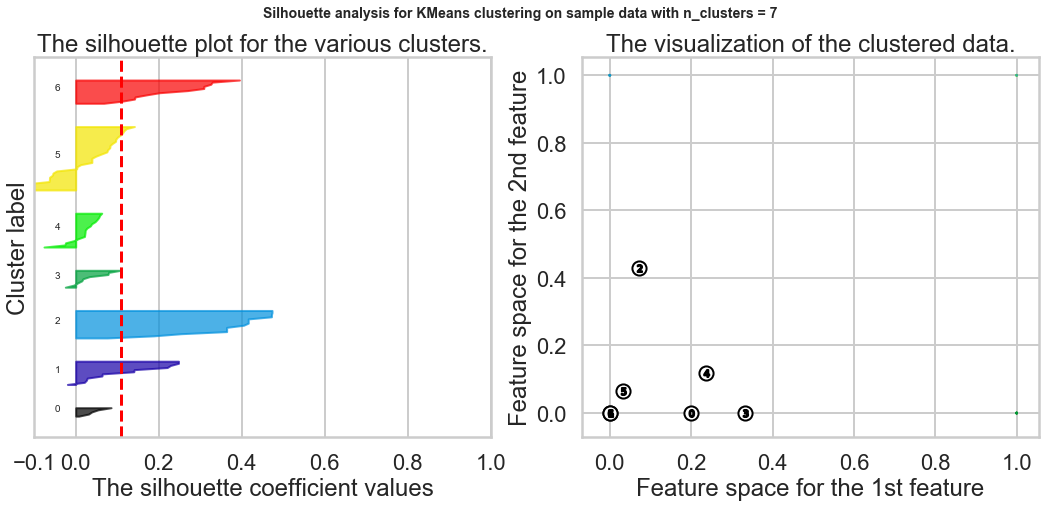

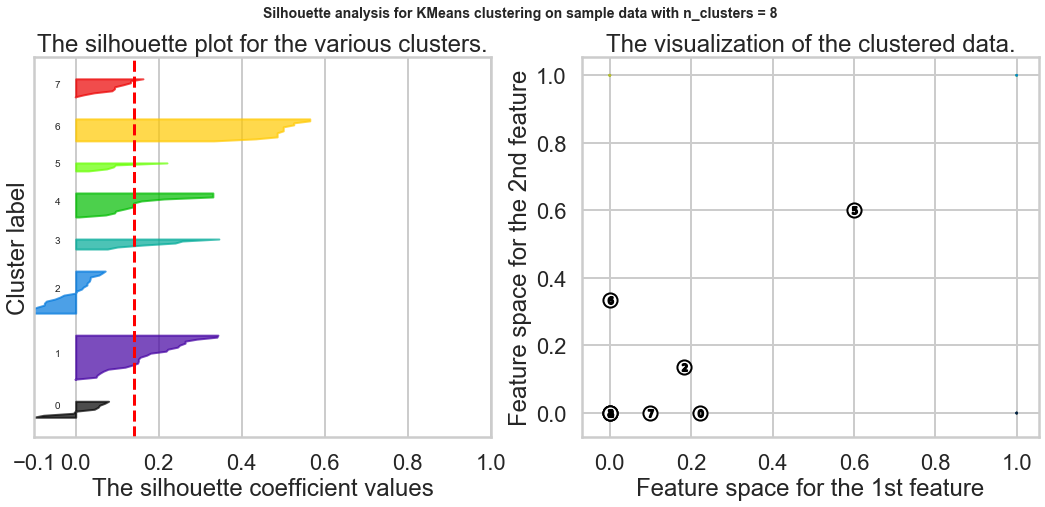

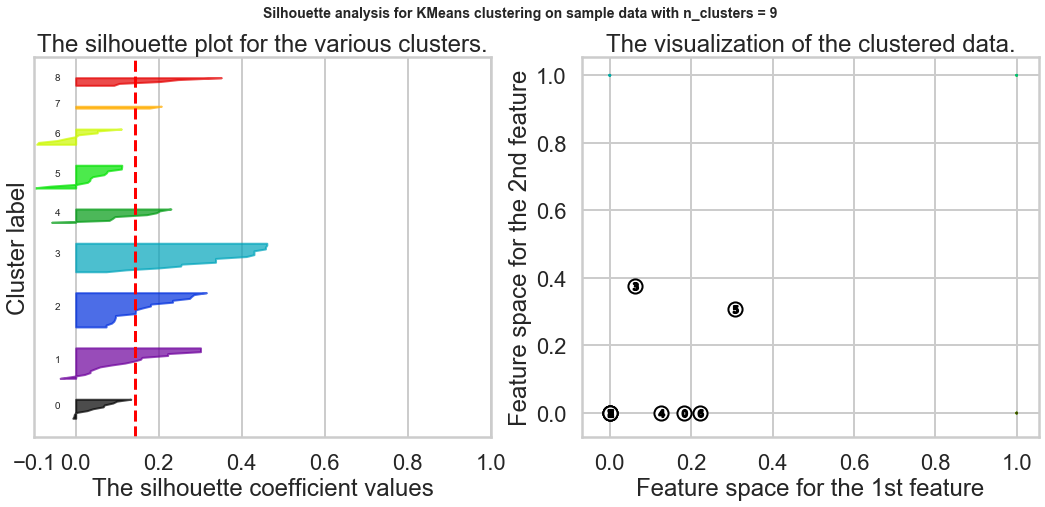

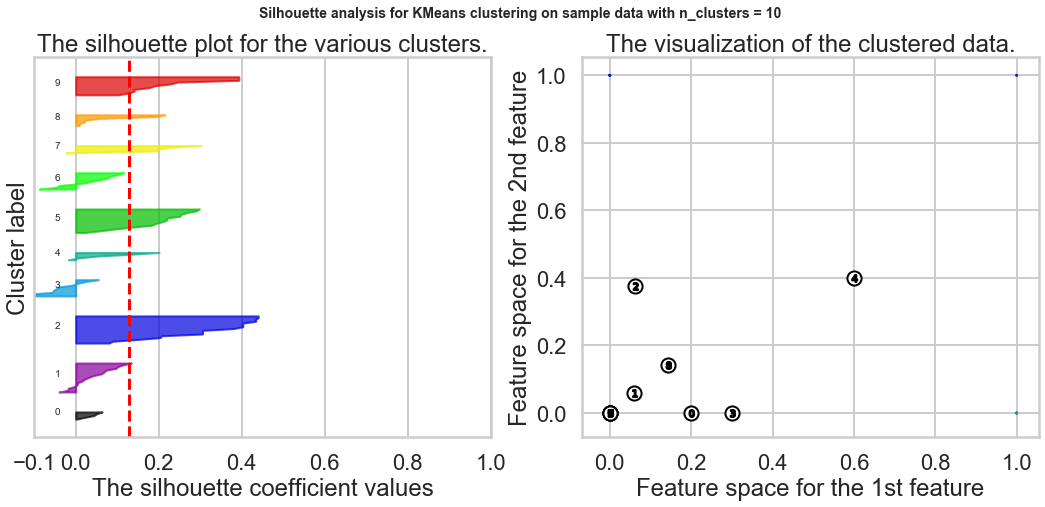

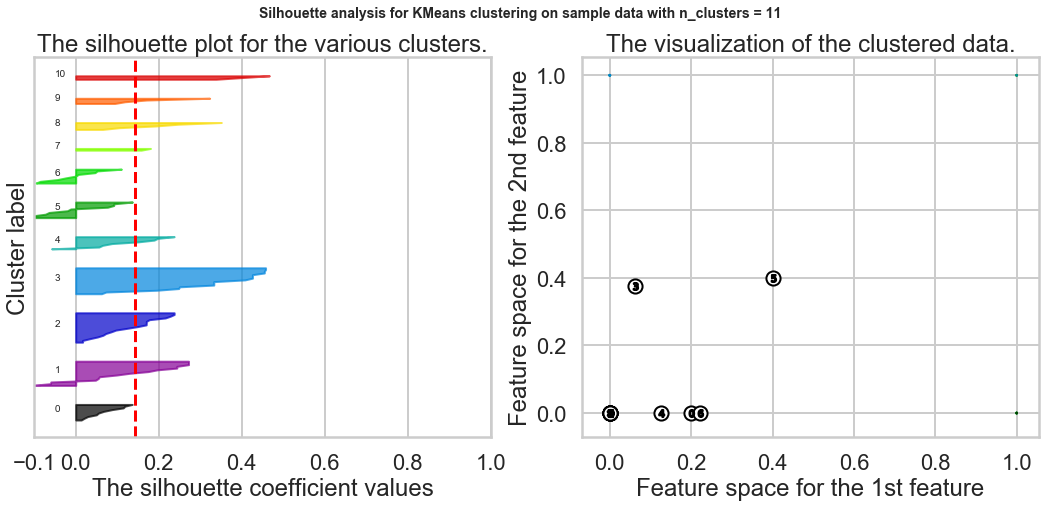

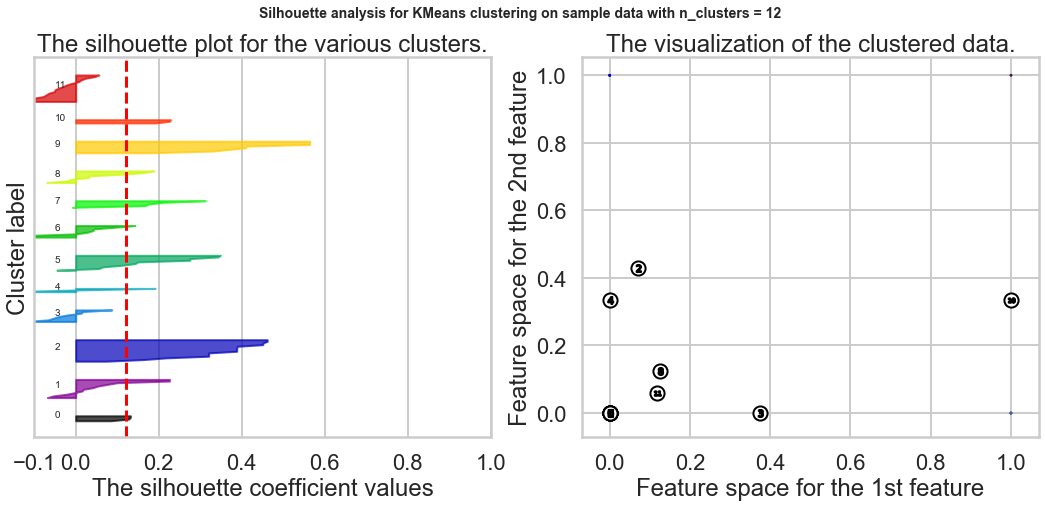

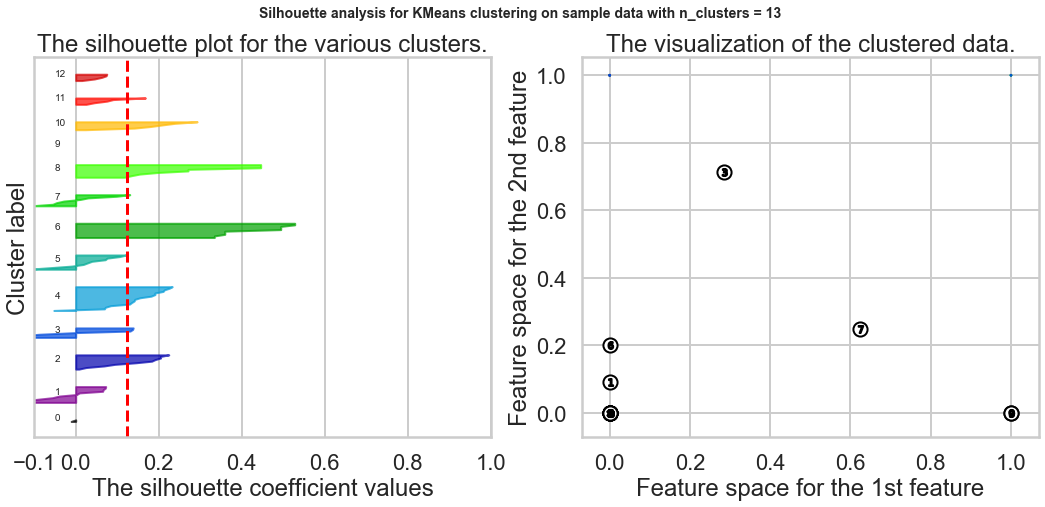

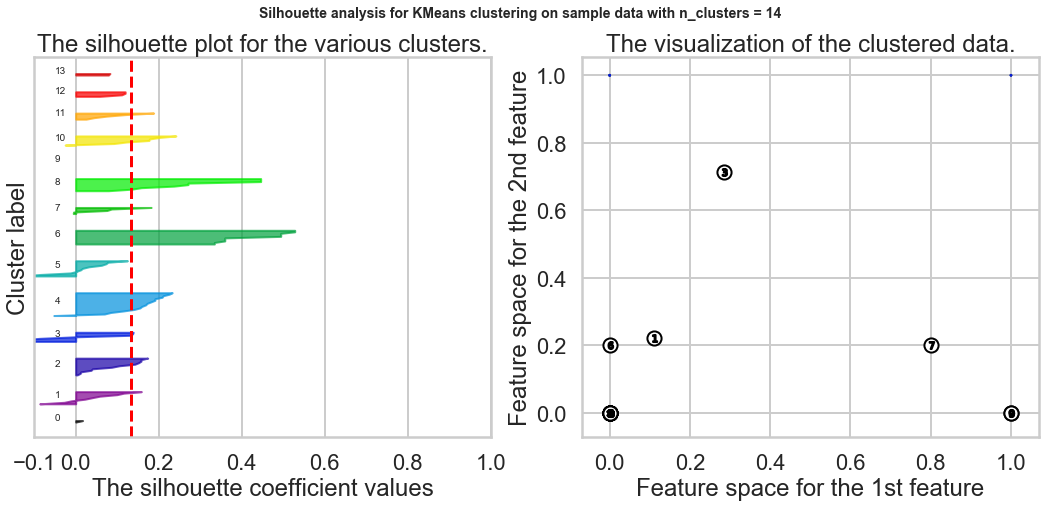

In [29]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

ls_k_sa = []

for n_clusters in range(2,15): # has to have at least 2 clusters to function properly
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    ls_k_sa.append([n_clusters, silhouette_avg])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x_cols[:, 0], x_cols[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
df_k_sa = pd.DataFrame(ls_k_sa, columns = ['k', 'sa'])

plt.show()

In [30]:
# df of silhouette averages vs. number of clusters
df_k_sa

,k,sa
0,2,0.091749
1,3,0.110718
2,4,0.123492
3,5,0.114829
4,6,0.118795
5,7,0.108746
6,8,0.140972
7,9,0.141786
8,10,0.128199
9,11,0.142905


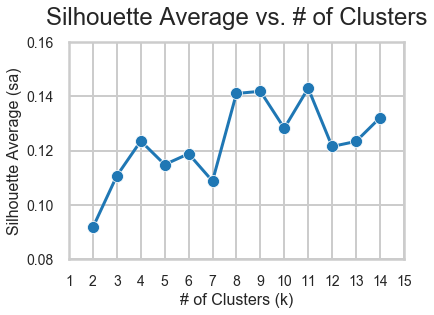

In [31]:
# plot silhouette averages vs. number of clusters

_ = sns.lineplot(x='k', 
                 y='sa', 
                 data=df_k_sa, 
                 marker='o')

_ = plt.title('Silhouette Average vs. # of Clusters', y=1.05)
_ = plt.xlabel('# of Clusters (k)', fontsize=16)
_ = plt.ylabel('Silhouette Average (sa)', fontsize=16)
_ = plt.xticks(range(1,16), fontsize = 14)
_ = plt.yticks([.08, .10, .12, .14, .16], fontsize = 14)

Reasons for selecting a k value:
* Clusters have above average silhouette scores
* Small fluctuations in the size of the silhouette plots

According to the 'Silhouette Average' plot above, when k=5 and k=10, the Silhouette Averages are the highest (0.141 and 0.144 respectively). As k increases, overfitting tends to occur. So the best k value would be 5 according to this method.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

#### 1. Use PCA  for dimension reduction to 2 components

In [32]:
# 1) Use PCA  for dimension reduction to 2 components

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(x_cols)

x_2 = pca.transform(x_cols)

df_x_2 = pd.DataFrame(x_2, columns=['C1','C2'])
df_x_2.head()

,C1,C2
0,1.007580,0.108215
1,-0.287539,0.044715
2,-0.392032,1.038391
3,0.699477,-0.022542
4,0.088183,-0.471695


#### Steps 2, 3, 4 (using original labels)

In [34]:
# 2) Create a data frame with the following fields:
# --- customer name
# --- cluster id the customer belongs to
# ---the two PCA components (label them x and y)

# number of clusters
k = 3

# initialize the model
model = KMeans(n_clusters=k, random_state=1)

# fit and predict the labels for each customer
labels = model.fit_predict(x_cols)

# list for each column of data
data = [list(matrix.index), 
        list(labels), 
        list(df_x_2.C1), 
        list(df_x_2.C2)]

# column names for df
cols = {0:'customer_name', 1:'labels', 2:'x', 3:'y'}

# create df with 4 cols of data
df_pca = pd.DataFrame(data).T.rename(columns=cols)

df_pca.head()

,customer_name,labels,x,y
0,Adams,1,1.00758,0.108215
1,Allen,2,-0.287539,0.0447145
2,Anderson,0,-0.392032,1.03839
3,Bailey,1,0.699477,-0.0225422
4,Baker,2,0.0881832,-0.471695


#### 3. Plot a scatterplot of the x vs y columns
#### 4. Color-code points differently based on cluster ID

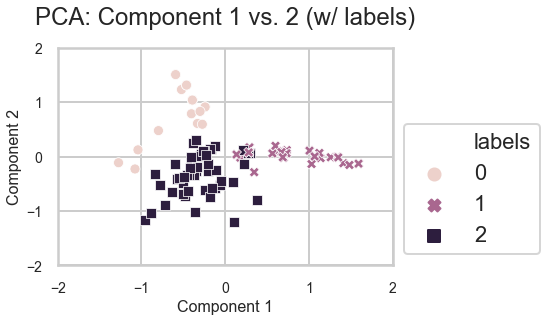

In [35]:
# 3) Plot a scatterplot of the x vs y columns
# 4) Color-code points differently based on cluster ID

_ = sns.scatterplot(x='x', 
                    y='y', 
                    hue='labels',
                    style='labels',
                    data=df_pca,
                    s=100, 
                    legend='full')

_ = plt.title('PCA: Component 1 vs. 2 (w/ labels)', y=1.08)
_ = plt.xlabel('Component 1', fontsize=16)
_ = plt.ylabel('Component 2', fontsize=16)
_ = plt.xticks([-2, -1, 0, 1, 2], fontsize = 14)
_ = plt.yticks([-2, -1, 0, 1, 2], fontsize = 14)
_ = plt.legend(loc=3, bbox_to_anchor=(1.0, 0.0))

#### Steps 2, 3, 4 (using pca generated labels)

In [38]:
# 2) Create a data frame with the following fields:
# --- customer name
# --- cluster id the customer belongs to
# ---the two PCA components (label them x and y)

# number of clusters
k = 3

# initialize the model
model = KMeans(n_clusters=k, random_state=1)

# fit and predict the labels for each customer
labels = model.fit_predict(df_x_2)

# list for each column of data
data = [list(matrix.index), # customer names
        list(labels), # cluster labels (0,1,2)
        list(df_x_2.C1), # component 1
        list(df_x_2.C2)] # component 2

# dict of column names for df
cols = {0:'customer_name', 
        1:'labels', 
        2:'x', 
        3:'y'}

# create df with 4 cols of data
df_pca = pd.DataFrame(data).T.rename(columns=cols) # create df, transform, rename columns

df_pca.head()

,customer_name,labels,x,y
0,Adams,2,1.00758,0.108215
1,Allen,0,-0.287539,0.0447145
2,Anderson,1,-0.392032,1.03839
3,Bailey,2,0.699477,-0.0225422
4,Baker,0,0.0881832,-0.471695


The blue markers are the cluster centroids.


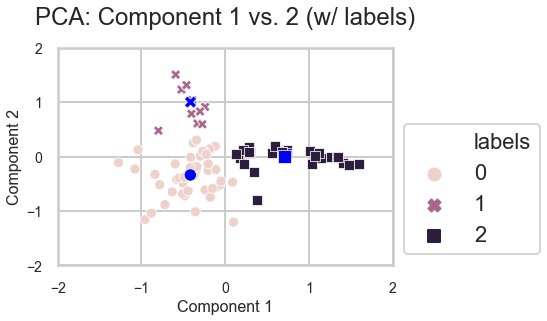

In [39]:
# 3) Plot a scatterplot of the x vs y columns
# 4) Color-code points differently based on cluster ID

# find the centers of the clusters
centers = pd.DataFrame(model.cluster_centers_, columns=['x','y'])
centers['labels'] = [0, 1, 2]

# plot the pca data points
_ = sns.scatterplot(x='x', 
                    y='y', 
                    hue='labels',
                    style='labels',
                    data=df_pca,
                    s=100, 
                    legend='full')

# plot the center points
_ = sns.scatterplot(x='x', 
                    y='y', 
                    data=centers,
                    style='labels',
                    s=150,
                    color='b',
                    legend=False)

_ = plt.title('PCA: Component 1 vs. 2 (w/ labels)', y=1.08)
_ = plt.xlabel('Component 1', fontsize=16)
_ = plt.ylabel('Component 2', fontsize=16)
_ = plt.xticks([-2, -1, 0, 1, 2], fontsize = 14)
_ = plt.yticks([-2, -1, 0, 1, 2], fontsize = 14)
_ = plt.legend(loc=3, bbox_to_anchor=(1.0, 0.0))

print('The blue markers are the cluster centroids.')

#### 5. How do the clusters look?
#### 6. Based on what you see, what seems to be the best value for  k ? Moreover, which method of choosing  k  seems to have produced the optimal result visually?

Labeling before PCA
* There are a few points that might manually be clustered in a different fashion, but overall, the data looks fairly well clustered into correct groups.
* Potentially label '0' could be broken into 3 sub groups, but then it might run into overfitting.

Labeling after PCA
* There is one square (label=2) and one circle (label=0) that might be labeled incorrectly, but basically all the data looks fairly well clustered into correct groups. Using PCA prior to labeling seems to be more accuracte in clustering the data into groups.
* Again, label 0 could potentially broken into 3 sub groups, but it might run into overfitting.

#### 7. Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

In [42]:
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [43]:
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [44]:
df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [45]:
# combine the pca df with the original data (both offers & transactions)

df_final = pd.merge(df_pca, df, on='customer_name')
df_final.head(10)

,customer_name,labels,x,y,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,n
0,Adams,2,1.00758,0.108215,18,July,Espumante,6,50,Oregon,False,1
1,Adams,2,1.00758,0.108215,29,November,Pinot Grigio,6,87,France,False,1
2,Adams,2,1.00758,0.108215,30,December,Malbec,6,54,France,False,1
3,Allen,0,-0.287539,0.0447145,9,April,Chardonnay,144,57,Chile,False,1
4,Allen,0,-0.287539,0.0447145,27,October,Champagne,72,88,New Zealand,False,1
5,Anderson,1,-0.392032,1.03839,24,September,Pinot Noir,6,34,Italy,False,1
6,Anderson,1,-0.392032,1.03839,26,October,Pinot Noir,144,83,Australia,False,1
7,Bailey,2,0.699477,-0.0225422,7,March,Prosecco,6,40,Australia,True,1
8,Bailey,2,0.699477,-0.0225422,30,December,Malbec,6,54,France,False,1
9,Baker,0,0.0881832,-0.471695,7,March,Prosecco,6,40,Australia,True,1


### Months vs. Labels

In [46]:
campaign_labels = pd.crosstab(df_final['labels'], df_final['campaign'])
campaign_labels = campaign_labels[['January', 'February', 'March', 
                                  'April', 'May', 'June', 
                                  'July', 'August', 'September', 
                                  'October', 'November', 'December']]
campaign_labels

campaign,January,February,March,April,May,June,July,August,September,October,November,December
labels,,,,,,,,,,,,
0,13,20,17,13,15,18,5,28,4,15,6,25
1,7,0,0,1,1,1,7,0,13,13,0,0
2,0,2,34,3,8,1,14,3,0,2,17,18


In [47]:
# melt df to create bar plot

temp = campaign_labels.copy() # make a temp df for the plot
temp.reset_index(inplace=True) # convert the index (labels) into a column
temp = pd.melt(temp, id_vars=['labels']) # melt the df into labels > campaign > value
temp.head()

,labels,campaign,value
0,0,January,13
1,1,January,7
2,2,January,0
3,0,February,20
4,1,February,0


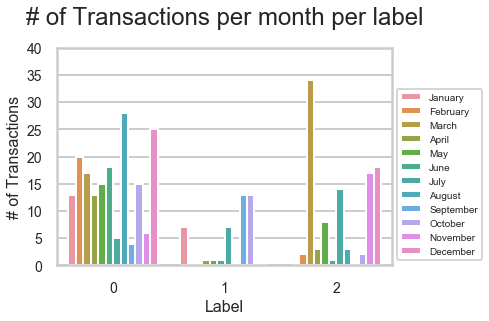

In [48]:
# plot # of Transactions vs. label and campaign

_ = sns.barplot(x='labels', 
                y='value', 
                data=temp, 
                hue='campaign')

_ = plt.title('# of Transactions per month per label', y=1.08)
_ = plt.xlabel('Label', fontsize=16)
_ = plt.ylabel('# of Transactions', fontsize=16)
_ = plt.xticks(fontsize = 14)
_ = plt.yticks([x for x in range(0, 41, 5)], fontsize = 14)
_ = plt.legend(loc=3, bbox_to_anchor=(1.0, 0.0), fontsize = 10)

* LABEL 0 = March and November were great
* LABEL 1 = January, February, April, May, June, and August were great
* LABEL 2 = September was a great
* LABELS SPLIT = July, October, and December were distributed between multiple labels

In [49]:
# create df with the months Feb, Jun, Aug and see how well they correlate with label 1
df_campaign = df_final[(df_final['campaign']=='February') |
                       (df_final['campaign']=='June') |
                       (df_final['campaign']=='August')]

df_campaign.head(10)

,customer_name,labels,x,y,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,n
14,Barnes,0,-0.485282,-0.725503,21,August,Champagne,12,50,California,False,1
15,Barnes,0,-0.485282,-0.725503,22,August,Champagne,72,63,France,False,1
23,Brooks,0,-0.118943,-0.577499,3,February,Espumante,144,32,Oregon,True,1
26,Brooks,0,-0.118943,-0.577499,22,August,Champagne,72,63,France,False,1
31,Butler,0,-0.240431,-0.617026,4,February,Champagne,72,48,France,True,1
32,Butler,0,-0.240431,-0.617026,22,August,Champagne,72,63,France,False,1
42,Clark,0,-0.579221,-0.420475,4,February,Champagne,72,48,France,True,1
50,Cooper,0,-0.406276,-0.0457711,4,February,Champagne,72,48,France,True,1
51,Cooper,0,-0.406276,-0.0457711,16,June,Merlot,72,88,California,False,1
52,Cooper,0,-0.406276,-0.0457711,20,August,Cabernet Sauvignon,72,82,Italy,False,1


The blue markers are the cluster centroids.


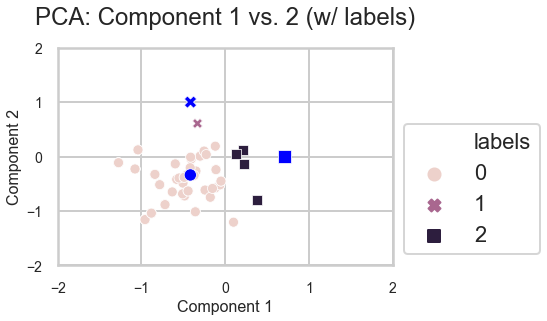

In [50]:
# plot the pca data points
_ = sns.scatterplot(x='x', 
                    y='y', 
                    hue='labels',
                    style='labels',
                    data=df_campaign,
                    s=100, 
                    legend='full')

# plot the pca center points
_ = sns.scatterplot(x='x', 
                    y='y', 
                    data=centers,
                    style='labels',
                    s=150,
                    color='b',
                    legend=False)

_ = plt.title('PCA: Component 1 vs. 2 (w/ labels)', y=1.08)
_ = plt.xlabel('Component 1', fontsize=16)
_ = plt.ylabel('Component 2', fontsize=16)
_ = plt.xticks([-2, -1, 0, 1, 2], fontsize = 14)
_ = plt.yticks([-2, -1, 0, 1, 2], fontsize = 14)
_ = plt.legend(loc=3, bbox_to_anchor=(1.0, 0.0))

print('The blue markers are the cluster centroids.')

### Varietal vs. Labels

In [51]:
varietal_labels = pd.crosstab(df_final['labels'], df_final['varietal'])
varietal_labels

varietal,Cabernet Sauvignon,Champagne,Chardonnay,Espumante,Malbec,Merlot,Pinot Grigio,Pinot Noir,Prosecco
labels,,,,,,,,,
0,30,74,13,8,13,12,1,7,21
1,0,1,1,0,1,1,0,37,2
2,2,6,1,32,18,7,16,0,20


In [52]:
# melt df to create bar plot

temp = varietal_labels.copy() # make a temp df for the plot
temp.reset_index(inplace=True) # convert the index (labels) into a column
temp = pd.melt(temp, id_vars=['labels']) # melt the df into labels > campaign > value
temp.head()

,labels,varietal,value
0,0,Cabernet Sauvignon,30
1,1,Cabernet Sauvignon,0
2,2,Cabernet Sauvignon,2
3,0,Champagne,74
4,1,Champagne,1


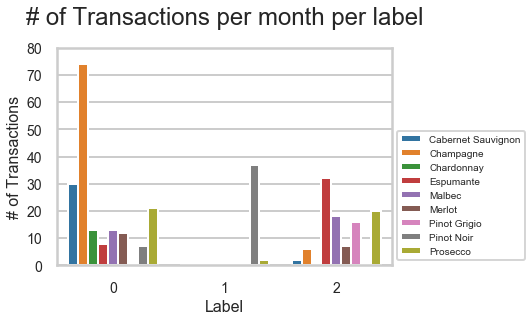

In [53]:
# plot # of Transactions vs. label and campaign

_ = sns.barplot(x='labels', 
                y='value', 
                data=temp, 
                hue='varietal')

_ = plt.title('# of Transactions per month per label', y=1.08)
_ = plt.xlabel('Label', fontsize=16)
_ = plt.ylabel('# of Transactions', fontsize=16)
_ = plt.xticks(fontsize = 14)
_ = plt.yticks([x for x in range(0, 81, 10)], fontsize = 14)
_ = plt.legend(loc=3, bbox_to_anchor=(1.0, 0.0), fontsize = 10)

* LABEL 0 = Espumante and Pinot Grigio were great
* LABEL 1 = Cabernet Sauvignon, Champagne, and Chardonnay were great
* LABEL 2 = Pinot Noir was a great
* LABELS SPLIT = Malbec, Merlot, and Prosecco were distributed between multiple labels

In [54]:
# create df with the varietals Cabernet Sauvignon, Champagne, and Chardonnay
# and see how well they correlate with label 1

df_varietal = df_final[(df_final['varietal']=='Cabernet Sauvignon') |
                       (df_final['varietal']=='Champagne') |
                       (df_final['varietal']=='Chardonnay')]

df_varietal.head(10)

,customer_name,labels,x,y,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,n
3,Allen,0,-0.287539,0.0447145,9,April,Chardonnay,144,57,Chile,False,1
4,Allen,0,-0.287539,0.0447145,27,October,Champagne,72,88,New Zealand,False,1
11,Baker,0,0.0881832,-0.471695,19,July,Champagne,12,66,Germany,False,1
12,Baker,0,0.0881832,-0.471695,31,December,Champagne,72,89,France,False,1
14,Barnes,0,-0.485282,-0.725503,21,August,Champagne,12,50,California,False,1
15,Barnes,0,-0.485282,-0.725503,22,August,Champagne,72,63,France,False,1
16,Barnes,0,-0.485282,-0.725503,31,December,Champagne,72,89,France,False,1
25,Brooks,0,-0.118943,-0.577499,11,May,Champagne,72,85,France,False,1
26,Brooks,0,-0.118943,-0.577499,22,August,Champagne,72,63,France,False,1
31,Butler,0,-0.240431,-0.617026,4,February,Champagne,72,48,France,True,1


The blue markers are the cluster centroids.


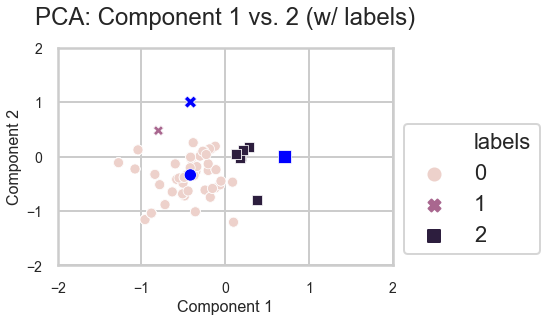

In [55]:
# plot the pca data points
_ = sns.scatterplot(x='x', 
                    y='y', 
                    hue='labels',
                    style='labels',
                    data=df_varietal,
                    s=100, 
                    legend='full')

# plot the pca center points
_ = sns.scatterplot(x='x', 
                    y='y', 
                    data=centers,
                    style='labels',
                    s=150,
                    color='b',
                    legend=False)

_ = plt.title('PCA: Component 1 vs. 2 (w/ labels)', y=1.08)
_ = plt.xlabel('Component 1', fontsize=16)
_ = plt.ylabel('Component 2', fontsize=16)
_ = plt.xticks([-2, -1, 0, 1, 2], fontsize = 14)
_ = plt.yticks([-2, -1, 0, 1, 2], fontsize = 14)
_ = plt.legend(loc=3, bbox_to_anchor=(1.0, 0.0))

print('The blue markers are the cluster centroids.')

### Origin vs. Labels

In [56]:
origin_labels = pd.crosstab(df_final['labels'], df_final['origin'])
origin_labels

origin,Australia,California,Chile,France,Germany,Italy,New Zealand,Oregon,South Africa
labels,,,,,,,,,
0,9,9,29,84,8,12,11,10,7
1,13,2,0,7,7,12,1,0,1
2,17,5,8,37,1,0,1,16,17


In [57]:
# melt df to create bar plot

temp = origin_labels.copy() # make a temp df for the plot
temp.reset_index(inplace=True) # convert the index (labels) into a column
temp = pd.melt(temp, id_vars=['labels']) # melt the df into labels > campaign > value
temp.head()

,labels,origin,value
0,0,Australia,9
1,1,Australia,13
2,2,Australia,17
3,0,California,9
4,1,California,2


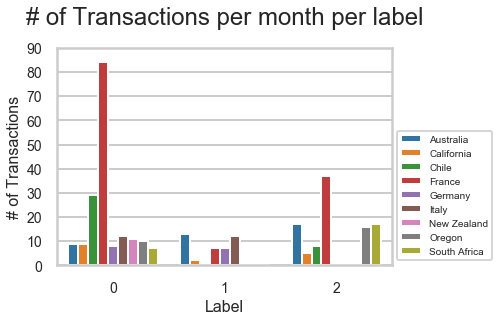

In [58]:
# plot # of Transactions vs. label and campaign

_ = sns.barplot(x='labels', 
                y='value', 
                data=temp, 
                hue='origin')

_ = plt.title('# of Transactions per month per label', y=1.08)
_ = plt.xlabel('Label', fontsize=16)
_ = plt.ylabel('# of Transactions', fontsize=16)
_ = plt.xticks(fontsize = 14)
_ = plt.yticks([x for x in range(0, 91, 10)], fontsize = 14)
_ = plt.legend(loc=3, bbox_to_anchor=(1.0, 0.0), fontsize = 10)

* LABEL 0 = South Africa did well
* LABEL 1 = Chile, France, and New Zealand were great
* LABEL 2 = None were great
* LABELS SPLIT = Australia, California, Germany, Italy, and Oregon were distributed between multiple labels

#### Origin and Varietal vs. Labels

In [59]:
o_v_labels = pd.crosstab(df_final['labels'], [df_final.origin, df_final.varietal])
o_v_labels['France']

varietal,Cabernet Sauvignon,Champagne,Malbec,Pinot Grigio,Pinot Noir
labels,,,,,
0,5,61,13,1,4
1,0,0,1,0,6
2,1,2,18,16,0


This is an example of the origin 'France' and the varietal crosstab
* When Origin=France and Varietal=Champagne, they are very highly correlated with Label 1

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

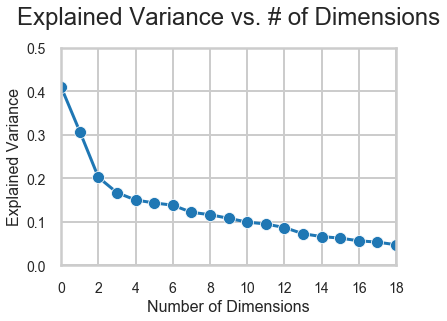

In [41]:
# Initialize a new PCA model with a default number of dimensions

# initializes the model
pca = PCA()

# fits the model with the x data
pca.fit(x_cols)

# save the # of dimensions and the respective explained variance
df_comp = pd.DataFrame(pca.explained_variance_, columns=['ev'])

# plot the explained variance vs # of dimensions
_ = sns.lineplot(x=df_comp.index, 
                 y='ev', 
                 data=df_comp, 
                 marker='o')

_ = plt.title('Explained Variance vs. # of Dimensions', y=1.08)
_ = plt.xlabel('Number of Dimensions', fontsize=16)
_ = plt.ylabel('Explained Variance', fontsize=16)
_ = plt.xlim([0,15])
_ = plt.ylim([0.0,0.5])
_ = plt.xticks([x for x in range(0, 20, 2)], fontsize = 14)
_ = plt.yticks([.0, .1, .2, .3, .4, .5], fontsize = 14)

According to the plot above, one possible value for the optimal number of dimensions could be 3. When PCA was first performed, the dimensions was set to 2 and by looking at the plot, that isn't an unreasonable value to set it to.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


# Affinity Propagation
·Parameters = Damping, sample preference

·Scalability = Not scalable with n_samples

·Use Case = Many clusters, uneven cluster size, non-flat geometry

·Geometry (metric used) = Graph distance (e.g. nearest-neighbor graph)

AffinityPropagation creates clusters by sending messages between pairs of samples until convergence. A dataset is then described using a small number of exemplars, which are identified as those most representative of other samples. The messages sent between pairs represent the suitability for one sample to be the exemplar of the other, which is updated in response to the values from other pairs. This updating happens iteratively until convergence, at which point the final exemplars are chosen, and hence the final clustering is given.

Affinity Propagation can be interesting as it chooses the number of clusters based on the data provided. For this purpose, the two important parameters are the preference, which controls how many exemplars are used, and the damping factor which damps the responsibility and availability messages to avoid numerical oscillations when updating these messages.

The main drawback of Affinity Propagation is its complexity. The algorithm has a time complexity of the order , where is the number of samples and is the number of iterations until convergence. Further, the memory complexity is of the order if a dense similarity matrix is used, but reducible if a sparse similarity matrix is used. This makes Affinity Propagation most appropriate for small to medium sized datasets.

In [36]:
# Use Affinity Propagation on x_cols

from sklearn.cluster import AffinityPropagation

# Damping factor (between 0.5 and 1) is the extent to which the current value is 
# maintained relative to incoming values (weighted 1 - damping). 
# This in order to avoid numerical oscillations when updating these values (messages).
ls_damp = [x/100 for x in range(50, 100, 5)]

# record damping value and score
ls_ap = []

for d in ls_damp:
    ap = AffinityPropagation(damping=d)
    labels = ap.fit_predict(x_cols)
    score = silhouette_score(x_cols, labels, random_state=1)
    ls_ap.append([d, score])

df_ap = pd.DataFrame(ls_ap, columns=['damping', 'score'])    
df_ap

,damping,score
0,0.50,0.123465
1,0.55,0.123465
2,0.60,0.123465
3,0.65,0.123465
4,0.70,0.123465
5,0.75,0.123465
6,0.80,0.089546
7,0.85,0.089546
8,0.90,0.089546
9,0.95,0.089546


Best Damping: 0.5
Best Score: 0.12346523604478911


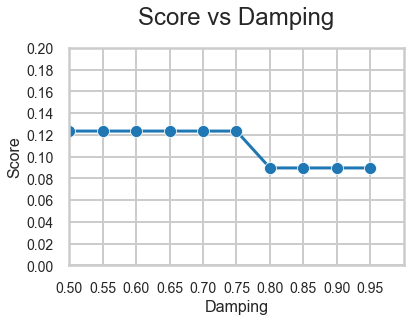

In [37]:
# find highest score, the damping value
# plot the scores vs damping value

print('Best Damping:', df_ap.damping.loc[df_ap.score.idxmax])
print('Best Score:', df_ap.score.max())

# plot the explained variance vs # of dimensions
_ = sns.lineplot(x='damping', 
                 y='score', 
                 data=df_ap, 
                 marker='o')

_ = plt.title('Score vs Damping', y=1.08)
_ = plt.xlabel('Damping', fontsize=16)
_ = plt.ylabel('Score', fontsize=16)
_ = plt.xlim([0.5,1])
_ = plt.ylim([0.0,0.2])
_ = plt.xticks([x/100 for x in range(50, 100, 5)], fontsize = 14)
_ = plt.yticks([.0, .02, .04, .06, .08, .10, .12, .14, .16, .18, .20], fontsize = 14)


# Spectral Clustering
* Parameters = Number of clusters	
* Scalability = Medium n_samples, small n_clusters	
* Use Case = Few clusters, even cluster size, non-flat geometry	
* Geometry (metric used) = Graph distance (e.g. nearest-neighbor graph)

Apply clustering to a projection to the normalized laplacian. In practice Spectral Clustering is very useful when the structure of the individual clusters is highly non-convex or more generally when a measure of the center and spread of the cluster is not a suitable description of the complete cluster. For instance when clusters are nested circles on the 2D plan.

In [29]:
# Your turn
# Affinity propagation
# Use Spectral Clustering on x_cols

from sklearn.cluster import SpectralClustering

# range of potential number of clusters
ls_clust = [x for x in range(2, 11, 1)]

# record number of clusters and score
ls_sc = []

for c in ls_clust:
    sc = SpectralClustering(n_clusters=c)
    labels = sc.fit_predict(x_cols)
    score = silhouette_score(x_cols, labels, random_state=1)
    ls_sc.append([c, score])

df_sc = pd.DataFrame(ls_sc, columns=['clusters', 'score'])    
df_sc

,clusters,score
0,2,0.076319
1,3,0.106115
2,4,0.086279
3,5,0.095379
4,6,0.105047
5,7,0.079954
6,8,0.098341
7,9,0.093675
8,10,0.092494


Best Clusters: 3
Best Score: 0.10611539040197304


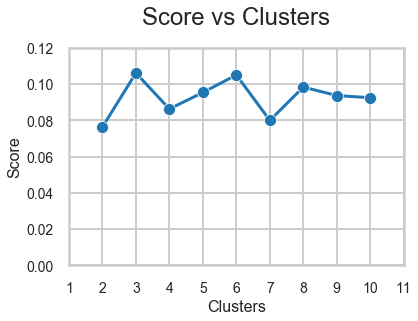

In [30]:
# find highest score, the number of clusters
# plot the scores vs # of clusters

print('Best Clusters:', df_sc.clusters.loc[df_sc.score.idxmax])
print('Best Score:', df_sc.score.max())

# plot the explained variance vs # of dimensions
_ = sns.lineplot(x='clusters', 
                 y='score', 
                 data=df_sc, 
                 marker='o')

_ = plt.title('Score vs Clusters', y=1.08)
_ = plt.xlabel('Clusters', fontsize=16)
_ = plt.ylabel('Score', fontsize=16)
_ = plt.xlim([1, 11])
_ = plt.ylim([0.0,0.12])
_ = plt.xticks([x for x in range(1, 12, 1)], fontsize = 14)
_ = plt.yticks([.0, .02, .04, .06, .08, .10, .12], fontsize = 14)

# Agglomerative Clustering
Parameters = Number of clusters, linkage type, distance
Scalability = Large n_samples and n_clusters
Use Case = Many clusters, possibly connectivity constraints, non Euclidean distances
Geometry (metric used) = Any pairwise distance
Recursively merges the pair of clusters that minimally increases a given linkage distance.

In [31]:
# Use Agglomerative Clustering on x_cols

from sklearn.cluster import AgglomerativeClustering

# range of potential number of clusters
ls_clust = [x for x in range(2, 11, 1)]

# record number of clusters and score
ls_ac = []

for c in ls_clust:
    ac = AgglomerativeClustering(n_clusters=c)
    labels = ac.fit_predict(x_cols)
    score = silhouette_score(x_cols, labels, random_state=1)
    ls_ac.append([c, score])

df_ac = pd.DataFrame(ls_ac, columns=['clusters', 'score'])    
df_ac

,clusters,score
0,2,0.082580
1,3,0.116259
2,4,0.128938
3,5,0.140897
4,6,0.147152
5,7,0.152752
6,8,0.155781
7,9,0.120751
8,10,0.097548


Best Clusters: 8
Best Score: 0.15578053718604024


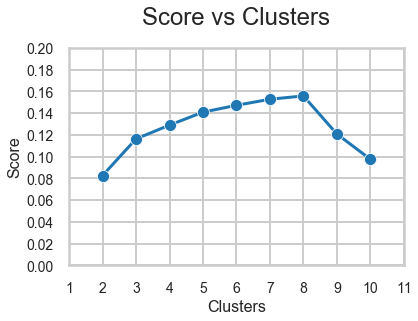

In [32]:
# find highest score, the number of clusters
# plot the scores vs # of clusters

print('Best Clusters:', df_ac.clusters.loc[df_ac.score.idxmax])
print('Best Score:', df_ac.score.max())

# plot the explained variance vs # of dimensions
_ = sns.lineplot(x='clusters', 
                 y='score', 
                 data=df_ac, 
                 marker='o')

_ = plt.title('Score vs Clusters', y=1.08)
_ = plt.xlabel('Clusters', fontsize=16)
_ = plt.ylabel('Score', fontsize=16)
_ = plt.xlim([1, 11])
_ = plt.ylim([0.0,0.12])
_ = plt.xticks([x for x in range(1, 12, 1)], fontsize = 14)
_ = plt.yticks([.0, .02, .04, .06, .08, .10, .12, .14, .16, .18, .20], fontsize = 14)

# DBSCAN
Parameters = Neighborhood size
Scalability = Very large n_samples, medium n_clusters
Use Case = Non-flat geometry, uneven cluster sizes
Geometry (metric used) = Distances between nearest points
Perform DBSCAN clustering from vector array or distance matrix. DBSCAN - Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density.

In [33]:
# Use DBSCAN on x_cols

from sklearn.cluster import DBSCAN

# range of potential min samples
ls_ms = [x for x in range(1, 4, 1)]

# record min samples and score
ls_db = []

for ms in ls_ms:
    db = DBSCAN(min_samples=ms)
    labels = db.fit_predict(x_cols)
    score = silhouette_score(x_cols, labels, random_state=1)
    ls_db.append([ms, score])

df_db = pd.DataFrame(ls_db, columns=['min_samples', 'score'])    
df_db

,min_samples,score
0,1,0.190000
1,2,-0.021678
2,3,-0.106636


Best Min Samples: 1
Best Score: 0.19


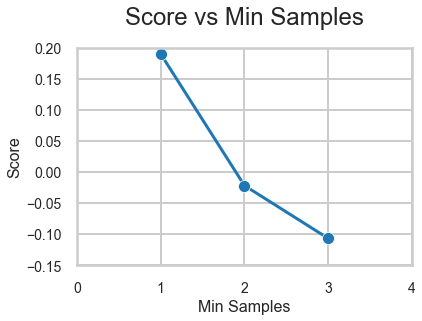

In [34]:
# find highest score, the min samples
# plot the scores vs min samples

print('Best Min Samples:', df_db.min_samples.loc[df_db.score.idxmax])
print('Best Score:', df_db.score.max())

# plot the explained variance vs # of dimensions
_ = sns.lineplot(x='min_samples', 
                 y='score', 
                 data=df_db, 
                 marker='o')

_ = plt.title('Score vs Min Samples', y=1.08)
_ = plt.xlabel('Min Samples', fontsize=16)
_ = plt.ylabel('Score', fontsize=16)
_ = plt.xlim([0, 4])
_ = plt.ylim([0.0,0.12])
_ = plt.xticks([0, 1, 2, 3, 4], fontsize = 14)
_ = plt.yticks([x/100 for x in range(-15, 21, 5)], fontsize = 14)

In [38]:
# Max Scores
print('AffinityPropagation:', df_ap.score.max())
print('SpectralClustering:', df_sc.score.max())
print('AgglomerativeClustering:', df_ac.score.max())
print('DBSCAN:', df_db.score.max())

AffinityPropagation: 0.12346523604478911
SpectralClustering: 0.10611539040197304
AgglomerativeClustering: 0.15578053718604024
DBSCAN: 0.19


Of the 4 algorithms, the DBSCAN had the highest score at 0.19. But that really isn't that high of a score. When the score is less than 0.25, "No substantial structure has been found". And with a minimum number of samples equal to 1, the model only accounts for the closest data point to assign it a label.